## Aerial view of Agriculture:~

### Imports

In [1]:
import cv2 
import matplotlib.pyplot as plt
import os


### Read Data

In [2]:
dta_path = "Agriculture"
dta = []
for filename in os.listdir(dta_path):
    dta.append(cv2.imread(f"{dta_path}//{filename}"))

## Exploratory Data Analysis

In [3]:
# Checking the shape of the data
dta[0].shape
# It can be said that the data is coloured with 256x256 pixels

(256, 256, 3)

In [4]:
# Checking data type for each image
type(dta[0])

numpy.ndarray

Text(0.5, 1.0, 'Image 4')

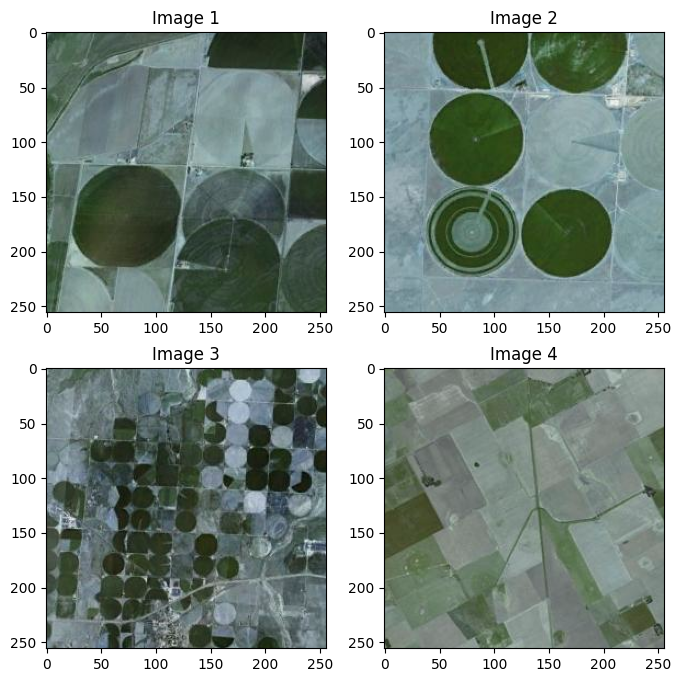

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Display images in each subplot
axes[0, 0].imshow(dta[6], cmap='gray')  # Grayscale
axes[0, 0].set_title("Image 1")

axes[0, 1].imshow(dta[1], cmap='gray')  # Grayscale with cmap
axes[0, 1].set_title("Image 2")

axes[1, 0].imshow(dta[2])  # RGB
axes[1, 0].set_title("Image 3")

axes[1, 1].imshow(dta[3])  # RGB
axes[1, 1].set_title("Image 4")

## Image Segmentation Techniques

### Edge Detection: Canny Edge Detection

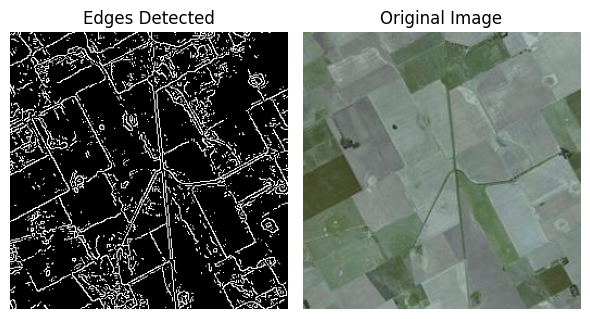

In [6]:
# Perform Canny Edge Detection
edges = cv2.Canny(dta[3], 50, 50)  

# Create a subplot with 2 rows and 1 column
fig, axes = plt.subplots(1, 2, figsize=(6, 8))

# Display edge-detected image
axes[0].imshow(edges, cmap='gray')
axes[0].set_title("Edges Detected")
axes[0].axis('off')

# Display the original image
axes[1].imshow(dta[3], cmap='gray')
axes[1].set_title("Original Image")
axes[1].axis('off')

# Adjust layout and show
plt.tight_layout()
plt.show()

## SLIC (Simple Linear Iterative Clustering)

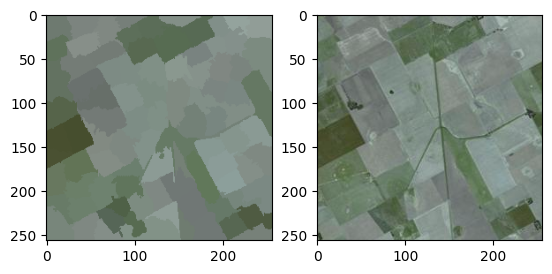

In [7]:
from skimage.segmentation import slic
from skimage.color import label2rgb

# Apply SLIC
segments = slic(dta[3], n_segments=100, compactness=10, start_label=1)
segmented_image = label2rgb(segments, dta[3], kind='avg')

fig, axes = plt.subplots(1,2)
axes[0].imshow(segmented_image)
axes[1].imshow(dta[3])

## Kmeans Clustering

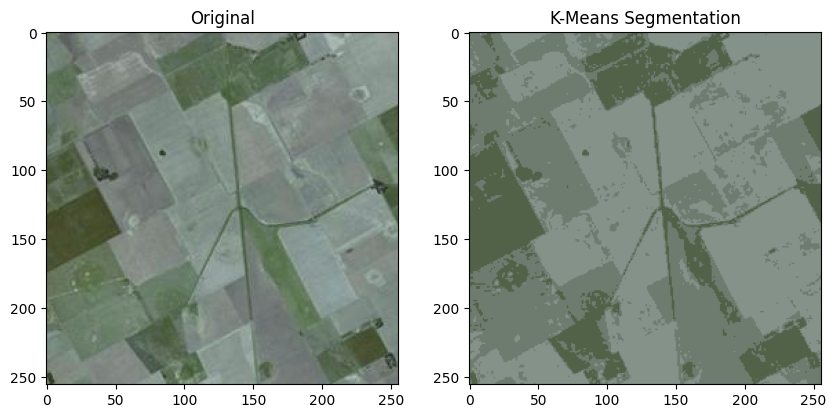

In [8]:
from sklearn.cluster import KMeans
img_rgb = dta[3]
# Flatten the image
pixels = img_rgb.reshape(-1, 3)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3).fit(pixels)
segmented = kmeans.cluster_centers_[kmeans.labels_].reshape(dta[3].shape)

# Display original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(segmented / 255)
plt.title("K-Means Segmentation")
plt.show()

## U-Net (PRETRAINED, NO TUNING)

In [11]:
import efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.2 MB/s eta 0:00:00a 0:00:01


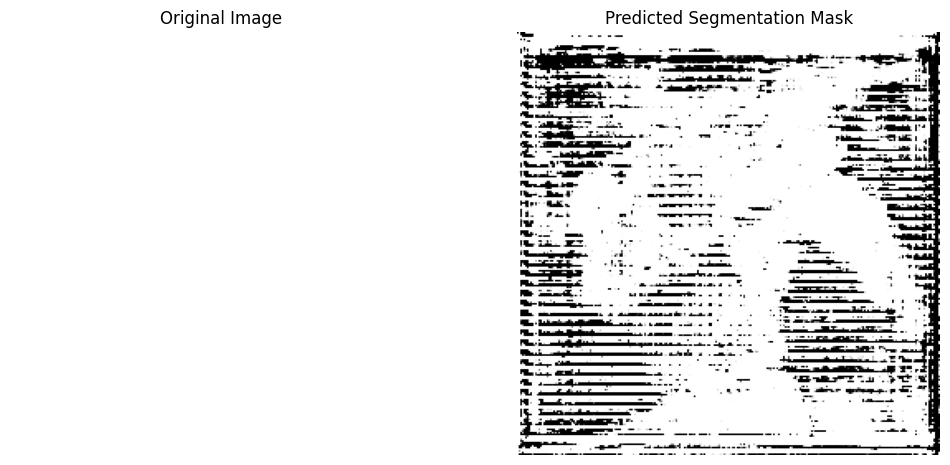

In [16]:
import segmentation_models_pytorch as smp
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assume dta[3] is your image tensor with shape [3, 256, 256]
# Ensure it's a float tensor
test_im = torch.as_tensor(dta[3]).float()

# Reshape to match the required shape: [batch_size, channels, height, width]
test_im = torch.reshape(test_im, [1, 3, 256, 256])

# Normalize the input (ImageNet normalization)
# Mean and std values for ImageNet
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

test_im = (test_im - mean) / std

# Load pretrained U-Net with ResNet34 backbone
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', classes=1, activation='sigmoid')

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    output = model(test_im)  # Use normalized input

# Convert the output tensor to a NumPy array
output_mask = output.squeeze().cpu().numpy()  # Remove batch dimension

# Visualize the original input image and the predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image (from the tensor, converted to NumPy)
original_image = test_im.squeeze().permute(1, 2, 0).cpu().numpy()  # [H, W, C]

# Undo the normalization to display the original image
original_image = original_image * std.numpy().squeeze() + mean.numpy().squeeze()
original_image = np.clip(original_image, 0, 1)  # Clip to [0, 1] range

# Display original image
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display predicted mask
axes[1].imshow(output_mask, cmap='gray')
axes[1].set_title("Predicted Segmentation Mask")
axes[1].axis('off')

plt.show()


In [26]:
import segmentation_models_pytorch as smp
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Load pretrained U-Net with ResNet34 backbone
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', classes=1, activation='sigmoid')

# Switch model to evaluation mode
model.eval()

# Load and preprocess an input image (size 256x256, 3 channels)
input_image = Image.open('path_to_your_image.jpg').convert('RGB')  # Update with your image path

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure the image is resized to 256x256
    transforms.ToTensor(),          # Convert image to tensor (normalize to [0, 1])
])

# Apply transformations to the image
input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension (shape: [1, 3, 256, 256])

# Perform inference
with torch.no_grad():
    output = model(input_tensor)

# Post-process the output to create a binary mask
output_mask = output.squeeze().cpu().numpy()  # Convert the output to a NumPy array

# Visualize the original image and the segmentation result
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show original image
axes[0].imshow(input_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Show the predicted mask (binary)
axes[1].imshow(output_mask, cmap='gray')
axes[1].set_title("Predicted Segmentation Mask")
axes[1].axis('off')

plt.show()


TypeError: Unexpected type <class 'numpy.ndarray'>